In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from scipy.stats import chi2_contingency

# --- Conexión y Carga de Datos desde la Tabla Final Corregida ---
client = bigquery.Client(project='co-keralty-costomedico')

# Consulta simple para traer todos los datos de la tabla ya procesada
sql_query = "SELECT * FROM `co-keralty-costomedico.Diabetes_avicena_survival.ANALISIS_ANTECEDENTES_FINAL`"

print("Cargando datos desde la tabla 'ANALISIS_ANTECEDENTES_FINAL'...")
df_analisis = client.query(sql_query).to_dataframe()

# Limpieza básica para asegurar los tipos de datos correctos
df_analisis['antecedente_familiar_enriquecido'] = pd.to_numeric(df_analisis['antecedente_familiar_enriquecido'], errors='coerce')
df_analisis.dropna(subset=['antecedente_familiar_enriquecido'], inplace=True) # Elimina filas si hay algún error
df_analisis['antecedente_familiar_enriquecido'] = df_analisis['antecedente_familiar_enriquecido'].astype(int)


# --- Conteo y Descripción de la Población ---
total_pacientes = len(df_analisis)
print(f"\n✅ ANÁLISIS EXPLORATORIO DE DIABETES\n{'-'*40}")
print(f"1. Total de pacientes analizados: {total_pacientes:,}")

print("\n2. Desglose por Hábito de Ejercicio:")
print(df_analisis['habito_ejercicio_1441'].value_counts())

print("\n3. Desglose por Antecedente Familiar de Diabetes:")
print(df_analisis['antecedente_familiar_enriquecido'].value_counts().rename(index={0: 'Sin Antecedente', 1: 'Con Antecedente'}))

Cargando datos desde la tabla 'ANALISIS_ANTECEDENTES_FINAL'...


/home/oscar_alvarezs/cloudshell_open/diabetes_avicena/venv-diabetes/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



✅ ANÁLISIS EXPLORATORIO DE DIABETES
----------------------------------------
1. Total de pacientes analizados: 953,712

2. Desglose por Hábito de Ejercicio:
habito_ejercicio_1441
No Registrado    434320
Nunca            277643
20 minutos       130716
40 minutos        59989
60 minutos        51044
Name: count, dtype: int64

3. Desglose por Antecedente Familiar de Diabetes:
antecedente_familiar_enriquecido
Sin Antecedente    933691
Con Antecedente     20021
Name: count, dtype: int64


📊 Iniciando Análisis Exploratorio Enriquecido...

--- Tabla de Resumen Detallada (con Intervalos de Confianza) ---


,total_pacientes,pacientes_con_diabetes,tasa_diabetes_%,CI_inferior_%,CI_superior_%
habito_ejercicio_1441,,,,,
20 minutos,130716,11954,9.15,8.99,9.3
40 minutos,59989,5394,8.99,8.76,9.22
Nunca,277643,22479,8.1,7.99,8.2
60 minutos,51044,3782,7.41,7.18,7.64
No Registrado,434320,21209,4.88,4.82,4.95


/tmp/ipykernel_2806/160696540.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


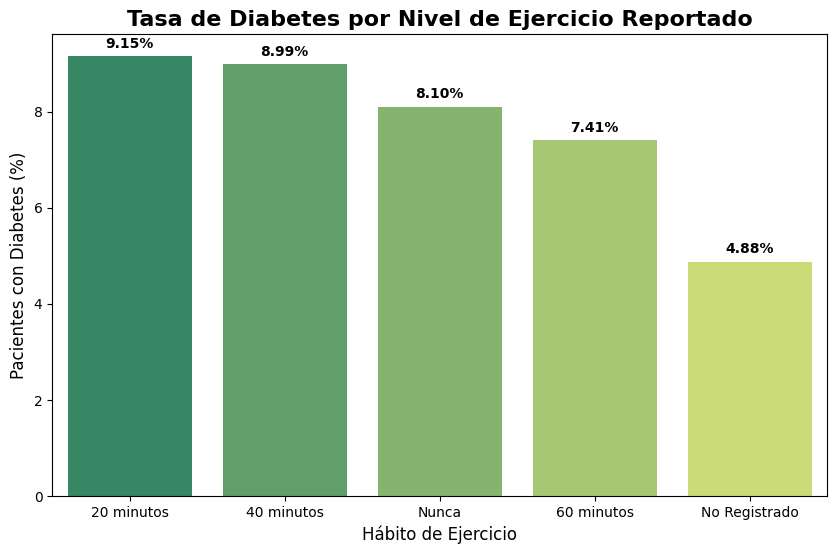


--- Prueba de Asociación Estadística (con Frecuencias Esperadas) ---

--- Frecuencias OBSERVADAS (Reales) ---


diabetes,0,1
habito_ejercicio_1441,,
20 minutos,118762,11954
40 minutos,54595,5394
60 minutos,47262,3782
No Registrado,413111,21209
Nunca,255164,22479



--- Frecuencias ESPERADAS (si no hubiera asociación) ---


diabetes,0,1
habito_ejercicio_1441,,
20 minutos,121832.029065,8883.970935
40 minutos,55911.912785,4077.087215
60 minutos,47574.849992,3469.150008
No Registrado,404801.913030,29518.086970
Nunca,258773.295127,18869.704873



Resultado del Test:
P-valor: 0.0000e+00
✅ La asociación es ESTADÍSTICAMENTE SIGNIFICATIVA.


In [2]:
import numpy as np 

print("📊 Iniciando Análisis Exploratorio Enriquecido...")

# --- 1. MEJORA CLAVE: Crear una tabla de resumen con Intervalos de Confianza ---
# Usamos groupby().agg() para calcular las estadísticas base
summary_ejercicio = df_analisis.groupby('habito_ejercicio_1441')['diabetes'].agg(
    total_pacientes='count',
    pacientes_con_diabetes='sum'
)

# Calculamos la tasa (proporción)
summary_ejercicio['tasa_diabetes'] = summary_ejercicio['pacientes_con_diabetes'] / summary_ejercicio['total_pacientes']

# 
z = 1.96
p = summary_ejercicio['tasa_diabetes']
n = summary_ejercicio['total_pacientes']
margen_de_error = z * np.sqrt(p * (1 - p) / n)

# Calculamos los límites inferior y superior del intervalo
summary_ejercicio['CI_inferior_%'] = ((p - margen_de_error) * 100).round(2)
summary_ejercicio['CI_superior_%'] = ((p + margen_de_error) * 100).round(2)

# Convertimos la tasa a porcentaje para la tabla final
summary_ejercicio['tasa_diabetes_%'] = (p * 100).round(2)

# Ordenamos y seleccionamos columnas para la presentación
summary_ejercicio = summary_ejercicio.sort_values(by='tasa_diabetes_%', ascending=False)
summary_ejercicio_display = summary_ejercicio[['total_pacientes', 'pacientes_con_diabetes', 'tasa_diabetes_%', 'CI_inferior_%', 'CI_superior_%']]


print("\n--- Tabla de Resumen Detallada (con Intervalos de Confianza) ---")
display(summary_ejercicio_display)


# --- 2. Visualización con Gráfico de Barras 
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=summary_ejercicio,
    x=summary_ejercicio.index,
    y='tasa_diabetes_%',
    palette='summer'
)
ax.set_title('Tasa de Diabetes por Nivel de Ejercicio Reportado', fontsize=16, weight='bold')
ax.set_xlabel('Hábito de Ejercicio', fontsize=12)
ax.set_ylabel('Pacientes con Diabetes (%)', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')
plt.show()

# --- 3. MEJORA CLAVE: Prueba de Chi-Cuadrado con Frecuencias Esperadas ---
print("\n--- Prueba de Asociación Estadística (con Frecuencias Esperadas) ---")
# Tabla de frecuencias observadas (la que ya teníamos)
contingency_table_observed = pd.crosstab(df_analisis['habito_ejercicio_1441'], df_analisis['diabetes'])
chi2, p_valor, dof, expected_freq = chi2_contingency(contingency_table_observed)

# Creamos un DataFrame con las frecuencias esperadas para compararlas
expected_table = pd.DataFrame(expected_freq,
                              index=contingency_table_observed.index,
                              columns=contingency_table_observed.columns)

print("\n--- Frecuencias OBSERVADAS (Reales) ---")
display(contingency_table_observed)
print("\n--- Frecuencias ESPERADAS (si no hubiera asociación) ---")
display(expected_table)

print(f"\nResultado del Test:")
print(f"P-valor: {p_valor:.4e}")
print("✅ La asociación es ESTADÍSTICAMENTE SIGNIFICATIVA.")

📊 Iniciando Análisis de la variable 'Antecedente Familiar'...

--- Tabla de Resumen Detallada: Antecedente Familiar vs. Diabetes ---


,total_pacientes,pacientes_con_diabetes,tasa_diabetes_%,CI_inferior_%,CI_superior_%
antecedente_familiar_enriquecido,,,,,
Con Antecedente,20021,2289,11.43,10.99,11.87
Sin Antecedente,933691,62529,6.7,6.65,6.75


/tmp/ipykernel_2806/2965085888.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


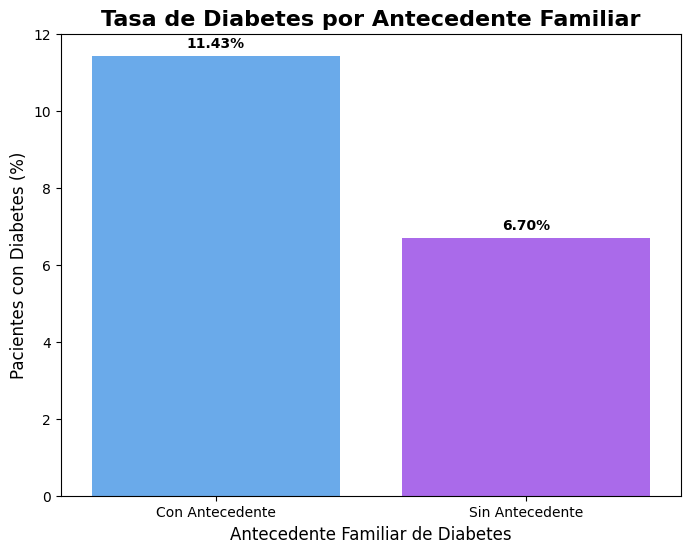


--- Prueba de Asociación Estadística (Chi-Cuadrado) ---
P-valor: 8.5668e-153
✅ La asociación entre el antecedente familiar y la diabetes es ESTADÍSTICAMENTE SIGNIFICATIVA.


In [3]:
print("📊 Iniciando Análisis de la variable 'Antecedente Familiar'...")

# --- 1. Crear una tabla de resumen detallada para Antecedente Familiar ---
# Agrupamos por la columna 'antecedente_familiar_enriquecido'
summary_familiar = df_analisis.groupby('antecedente_familiar_enriquecido')['diabetes'].agg(
    total_pacientes='count',
    pacientes_con_diabetes='sum'
)

# Calculamos la tasa (proporción)
summary_familiar['tasa_diabetes'] = summary_familiar['pacientes_con_diabetes'] / summary_familiar['total_pacientes']

# Calculamos el Intervalo de Confianza del 95% para la tasa
z = 1.96
p = summary_familiar['tasa_diabetes']
n = summary_familiar['total_pacientes']
margen_de_error = z * np.sqrt(p * (1 - p) / n)

summary_familiar['CI_inferior_%'] = ((p - margen_de_error) * 100).round(2)
summary_familiar['CI_superior_%'] = ((p + margen_de_error) * 100).round(2)
summary_familiar['tasa_diabetes_%'] = (p * 100).round(2)

# Añadimos etiquetas descriptivas para una mejor presentación
summary_familiar.index = summary_familiar.index.map({0: 'Sin Antecedente', 1: 'Con Antecedente'})

# Seleccionamos y ordenamos columnas
summary_familiar_display = summary_familiar[['total_pacientes', 'pacientes_con_diabetes', 'tasa_diabetes_%', 'CI_inferior_%', 'CI_superior_%']].sort_values(by='tasa_diabetes_%', ascending=False)

print("\n--- Tabla de Resumen Detallada: Antecedente Familiar vs. Diabetes ---")
display(summary_familiar_display)


# --- 2. Visualización con un Gráfico de Barras ---
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=summary_familiar_display,
    x=summary_familiar_display.index,
    y='tasa_diabetes_%',
    palette='cool'
)
ax.set_title('Tasa de Diabetes por Antecedente Familiar', fontsize=16, weight='bold')
ax.set_xlabel('Antecedente Familiar de Diabetes', fontsize=12)
ax.set_ylabel('Pacientes con Diabetes (%)', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')
plt.show()


# --- 3. Prueba Estadística de Chi-Cuadrado ---
print("\n--- Prueba de Asociación Estadística (Chi-Cuadrado) ---")
contingency_table_familiar = pd.crosstab(df_analisis['antecedente_familiar_enriquecido'], df_analisis['diabetes'])
chi2, p_valor, dof, expected = chi2_contingency(contingency_table_familiar)

print(f"P-valor: {p_valor:.4e}")
if p_valor < 0.05:
    print("✅ La asociación entre el antecedente familiar y la diabetes es ESTADÍSTICAMENTE SIGNIFICATIVA.")
else:
    print("❌ La asociación no es estadísticamente significativa.")

📊 Iniciando Análisis Combinado de Factores de Riesgo...

--- Tabla de Tasas de Diabetes (%) por Grupo Combinado ---


antecedente_familiar_enriquecido,Con Antecedente,Sin Antecedente
habito_ejercicio_1441,,
60 minutos,12.434018,7.235655
40 minutos,12.850812,8.856413
20 minutos,12.854402,9.006943
Nunca,12.353472,7.973914
No Registrado,6.630123,4.86772


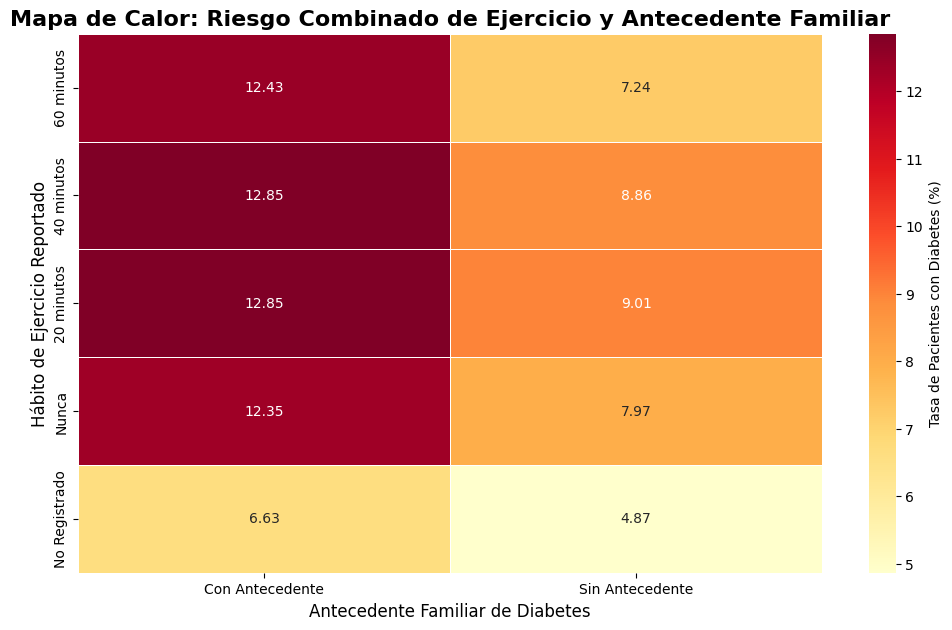

In [4]:
print("📊 Iniciando Análisis Combinado de Factores de Riesgo...")

# --- 1. Crear la tabla de interacción ---
tabla_riesgo_combinado = pd.crosstab(
    index=df_analisis['habito_ejercicio_1441'],
    columns=df_analisis['antecedente_familiar_enriquecido'].map({0: 'Sin Antecedente', 1: 'Con Antecedente'}),
    values=df_analisis['diabetes'],
    aggfunc='mean'
).mul(100)

# Ordenamos el índice para una mejor visualización en el gráfico
categorias_ordenadas = ['60 minutos', '40 minutos', '20 minutos', 'Nunca', 'No Registrado']
tabla_riesgo_combinado = tabla_riesgo_combinado.reindex(categorias_ordenadas)

print("\n--- Tabla de Tasas de Diabetes (%) por Grupo Combinado ---")
display(tabla_riesgo_combinado)


# --- 2. Visualización con Mapa de Calor ---
plt.figure(figsize=(12, 7))

# === CORRECCIÓN CLAVE ===
# Aseguramos que el tipo de dato de la tabla sea numérico (float) antes de graficar.
tabla_riesgo_combinado = tabla_riesgo_combinado.astype(float)

sns.heatmap(
    tabla_riesgo_combinado,
    annot=True, fmt=".2f", cmap="YlOrRd",
    linewidths=.5, cbar_kws={'label': 'Tasa de Pacientes con Diabetes (%)'}
)
plt.title('Mapa de Calor: Riesgo Combinado de Ejercicio y Antecedente Familiar', fontsize=16, weight='bold')
plt.xlabel('Antecedente Familiar de Diabetes', fontsize=12)
plt.ylabel('Hábito de Ejercicio Reportado', fontsize=12)
plt.show()

📊 Iniciando Análisis de Riesgo por Grupo de Edad...

--- Tabla de Resumen: Tasa de Diabetes (%) por Grupo de Edad ---


/tmp/ipykernel_2806/2662913761.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_edad = df_analisis.groupby('grupo_edad')['diabetes'].agg(


,grupo_edad,total_pacientes,pacientes_con_diabetes,tasa_diabetes_%
0,18-30,73210,1026,1.4
1,31-40,135754,3489,2.57
2,41-50,190066,7842,4.13
3,51-60,225603,16088,7.13
4,61-70,187698,18906,10.07
5,71+,141380,17467,12.35


/tmp/ipykernel_2806/2662913761.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


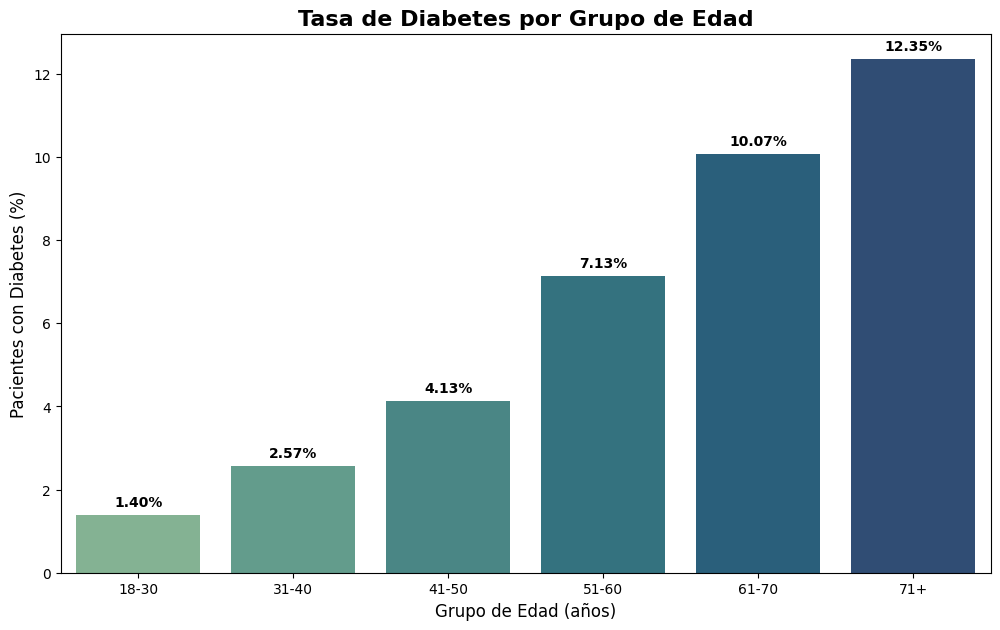

In [5]:
print("📊 Iniciando Análisis de Riesgo por Grupo de Edad...")

# --- 1. Creación de Grupos de Edad (Binning) ---
# Definimos los límites para nuestros rangos de edad.
bins = [18, 30, 40, 50, 60, 70, 110] # Los rangos serán 18-30, 31-40, etc.
# Definimos las etiquetas para cada rango.
labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71+']

# Usamos la función pd.cut() para crear una nueva columna con el grupo de edad correspondiente a cada paciente.
df_analisis['grupo_edad'] = pd.cut(df_analisis['edad'], bins=bins, labels=labels, right=False)


# --- 2. Crear una tabla de resumen para los grupos de edad ---
# Usamos la misma técnica enriquecida que antes.
summary_edad = df_analisis.groupby('grupo_edad')['diabetes'].agg(
    total_pacientes='count',
    pacientes_con_diabetes='sum'
).reset_index()

summary_edad['tasa_diabetes_%'] = (summary_edad['pacientes_con_diabetes'] / summary_edad['total_pacientes'] * 100).round(2)

print("\n--- Tabla de Resumen: Tasa de Diabetes (%) por Grupo de Edad ---")
display(summary_edad)


# --- 3. Visualización con un Gráfico de Barras ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=summary_edad,
    x='grupo_edad',
    y='tasa_diabetes_%',
    palette='crest'
)
ax.set_title('Tasa de Diabetes por Grupo de Edad', fontsize=16, weight='bold')
ax.set_xlabel('Grupo de Edad (años)', fontsize=12)
ax.set_ylabel('Pacientes con Diabetes (%)', fontsize=12)

# Añadir etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')
plt.show()

📊 Iniciando Análisis de Interacción: Edad, Ejercicio y Riesgo de Diabetes...

--- Tabla de Tasas de Diabetes (%) por Grupo de Edad y Ejercicio ---


/tmp/ipykernel_2806/1804582972.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_interaccion = df_interaccion.groupby(['grupo_edad', 'habito_ejercicio_1441'])['diabetes'].agg(


habito_ejercicio_1441,20 minutos,40 minutos,60 minutos,Nunca
grupo_edad,,,,
18-30,2.33,2.52,1.61,1.92
31-40,3.74,3.99,2.86,3.55
41-50,5.79,6.35,5.72,5.41
51-60,9.19,9.8,9.34,8.71
61-70,12.37,12.04,11.98,12.08
71+,14.3,14.42,14.3,14.21


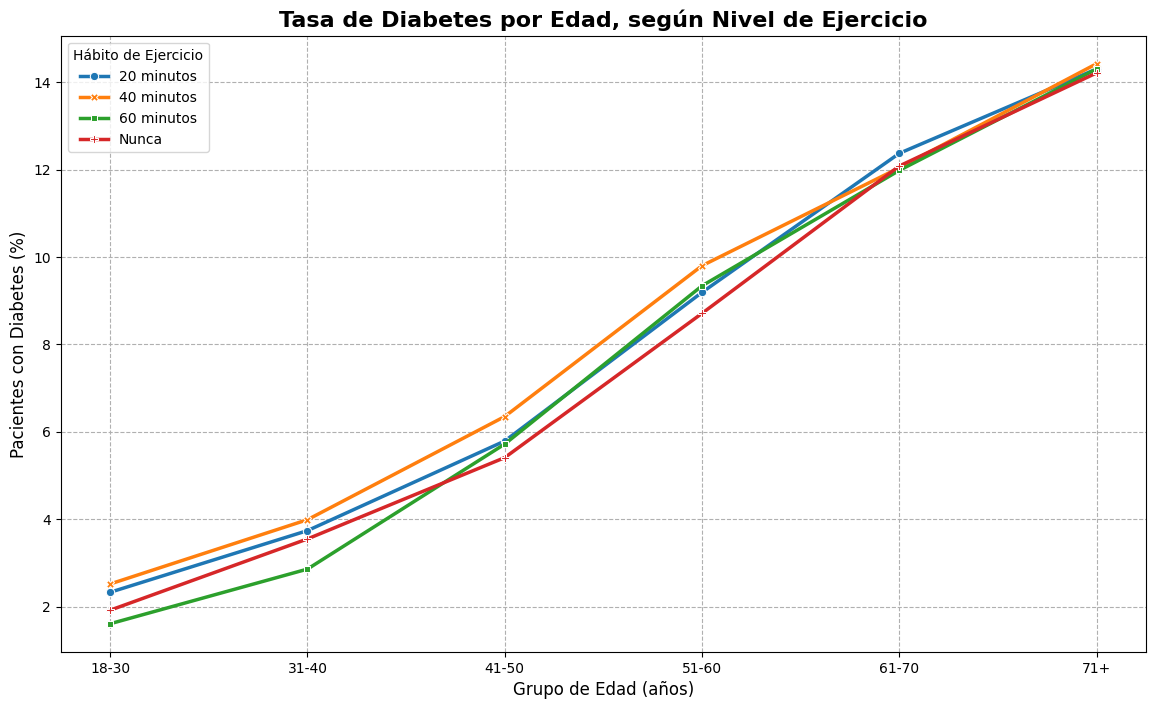

In [6]:
print("📊 Iniciando Análisis de Interacción: Edad, Ejercicio y Riesgo de Diabetes...")

# --- 1. Crear una tabla de resumen para la interacción ---
# Agrupamos por grupo de edad Y por hábito de ejercicio para obtener la tasa de cada subgrupo.
# Excluimos al grupo 'No Registrado' para centrarnos en los hábitos reportados.
df_interaccion = df_analisis[df_analisis['habito_ejercicio_1441'] != 'No Registrado'].copy()

summary_interaccion = df_interaccion.groupby(['grupo_edad', 'habito_ejercicio_1441'])['diabetes'].agg(
    tasa_diabetes='mean'
).mul(100).round(2).reset_index()


print("\n--- Tabla de Tasas de Diabetes (%) por Grupo de Edad y Ejercicio ---")
# Usamos .pivot para organizar mejor la tabla para visualización
display(summary_interaccion.pivot(index='grupo_edad', columns='habito_ejercicio_1441', values='tasa_diabetes'))


# --- 2. Visualización con un Gráfico de Líneas ---
plt.figure(figsize=(14, 8))
ax = sns.lineplot(
    data=summary_interaccion,
    x='grupo_edad',
    y='tasa_diabetes',
    hue='habito_ejercicio_1441', # 'hue' crea una línea de color para cada categoría de ejercicio
    style='habito_ejercicio_1441', # 'style' le da un marcador diferente a cada línea
    markers=True,
    dashes=False,
    linewidth=2.5
)
ax.set_title('Tasa de Diabetes por Edad, según Nivel de Ejercicio', fontsize=16, weight='bold')
ax.set_xlabel('Grupo de Edad (años)', fontsize=12)
ax.set_ylabel('Pacientes con Diabetes (%)', fontsize=12)
ax.grid(True, which='both', linestyle='--')
plt.legend(title='Hábito de Ejercicio')
plt.show()

📊 Iniciando Análisis de Incidencia por Tipo de Parentesco...
Cargando datos detallados de parentesco...


/home/oscar_alvarezs/cloudshell_open/diabetes_avicena/venv-diabetes/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(



--- Tabla de Resumen: Tasa de Diabetes (%) por Tipo de Parentesco ---


,parentesco,total_menciones,casos_con_diabetes,tasa_diabetes_%
4,Hija,117,33,28.21
5,Hijo,227,59,25.99
2,Hermana,1906,329,17.26
3,Hermano,2359,399,16.91
6,Madre,8219,1162,14.14
9,Primo,409,56,13.69
7,Padre,5429,625,11.51
8,Prima,143,15,10.49
10,Tía,1768,167,9.45
11,Tío,1973,184,9.33


/tmp/ipykernel_2806/3885173125.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


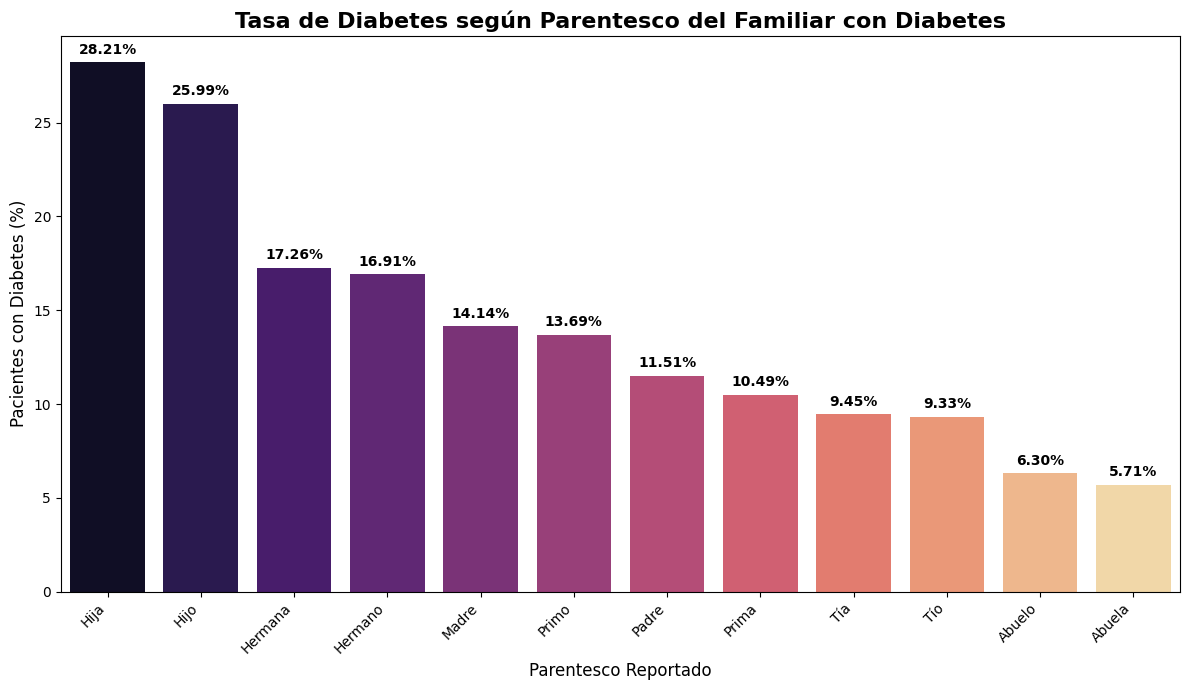

In [7]:
# --- Análisis Adicional: Incidencia de Diabetes por Tipo de Parentesco ---
print("📊 Iniciando Análisis de Incidencia por Tipo de Parentesco...")

# 1. --- Consulta SQL para obtener los datos detallados ---
# Esta consulta une la cohorte con CADA respuesta de antecedente familiar (pregunta 3621).
# Si un paciente reportó un padre y una madre, aparecerá dos veces en este set de datos,
# lo que nos permite analizar el impacto de cada tipo de parentesco.
sql_parentesco_query = """
    SELECT
      a.RESPUESTA_FINAL_PACIENTE AS parentesco,
      b.diabetes
    FROM
      `co-keralty-costomedico.Antecedentes_avicena.RPT_FOLIOS_PREGUNTAS_RESPUESTAS_PACIENTES_DEFINITIVA_PRUEBA` AS a
    INNER JOIN
      `co-keralty-costomedico.Diabetes_avicena_survival.ANALISIS_ANTECEDENTES_FINAL` AS b
      ON a.NUMERO_IDENTIFICACION = b.numero_identificacion_paciente
    WHERE
      a.PREGUNTA = 3621
      AND LOWER(a.RESPUESTA_FINAL_PACIENTE) != 'ninguno'
"""

# --- Carga de Datos en un nuevo DataFrame ---
print("Cargando datos detallados de parentesco...")
df_parentesco = client.query(sql_parentesco_query).to_dataframe()

# 2. --- Crear la tabla de resumen ---
# Agrupamos por el parentesco para calcular las tasas
summary_parentesco = df_parentesco.groupby('parentesco')['diabetes'].agg(
    total_menciones='count',
    casos_con_diabetes='sum'
).reset_index()

# Calculamos la tasa de diabetes
summary_parentesco['tasa_diabetes_%'] = (summary_parentesco['casos_con_diabetes'] / summary_parentesco['total_menciones'] * 100).round(2)

# Filtro de calidad: nos quedamos con los grupos con un número significativo de menciones (ej. más de 100)
# para que el cálculo de la tasa sea estadísticamente más estable.
summary_parentesco_filtrado = summary_parentesco[summary_parentesco['total_menciones'] > 100].copy()
summary_parentesco_filtrado = summary_parentesco_filtrado.sort_values(by='tasa_diabetes_%', ascending=False)

print("\n--- Tabla de Resumen: Tasa de Diabetes (%) por Tipo de Parentesco ---")
display(summary_parentesco_filtrado)

# 3. --- Visualización con un Gráfico de Barras ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=summary_parentesco_filtrado,
    x='parentesco',
    y='tasa_diabetes_%',
    palette='magma'
)
ax.set_title('Tasa de Diabetes según Parentesco del Familiar con Diabetes', fontsize=16, weight='bold')
ax.set_xlabel('Parentesco Reportado', fontsize=12)
ax.set_ylabel('Pacientes con Diabetes (%)', fontsize=12)

# Añadir etiquetas de porcentaje
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', weight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()